# Processing 20210621-rpb1egfp-eve-em2-02-09

In [1]:
# Import my packages.
import flymovie as fm

## 1. Read input files

In [2]:
# Set channels corresponding to nuclear signal and MS2 spots.
nucchannel = 0
spotchannel = 1

surface_before = 1467.45
surface_after = 1460.41

# Set files for output movie object and input files.
czi_folder = '/Volumes/stad3/2021-07-01'

czi_files = ['202106701-rpb1egfp-sna-em3-01.czi',
    '202106701-rpb1egfp-sna-em3-02.czi',
    '202106701-rpb1egfp-sna-em3-03.czi',
    '202106701-rpb1egfp-sna-em3-04.czi',
    '202106701-rpb1egfp-sna-em3-05.czi',
    '202106701-rpb1egfp-sna-em3-06.czi',
    '202106701-rpb1egfp-sna-em3-07.czi',  
]

outputfile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210701-rpb1egfp-sna-em3-01-07.pkl'

In [3]:
# Read and join czi files into single image stack, recording frames at which movies
# are joined and starting Z positions; view stack.
stack, join_frames, starting_positions, z_interval = fm.read_czi_multiple(czi_files, czi_folder)
fm.viewer(stack, 10, zmax=True)

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

## 2. Nuclear Segmentation
### 2-1 Determine parameters for segmentation of nuclei.

In [4]:
# Perform initial nuclear segmentation using the first few frames to determine parameters.
min_nuc_center_dist = 30
sigma = 5
usemax = True

nucmask_test = fm.segment_nuclei_4dstack(stack[nucchannel, :2], fm.segment_nuclei_3Dstack_rpb1, min_nuc_center_dist=min_nuc_center_dist, sigma=sigma, usemax=usemax)
fm.viewer(nucmask_test, 10, color='prism')

1 


interactive(children=(Dropdown(description='Color', index=6, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

### 2-2. Perform initial segmentation

In [5]:
# Segment nuclei using parameters determined above.
nucmask_init = fm.segment_nuclei_4dstack(stack[nucchannel], fm.segment_nuclei_3Dstack_rpb1, min_nuc_center_dist=min_nuc_center_dist, sigma=sigma, usemax=usemax)
fm.viewer(nucmask_init, figsize=10, color='prism')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 


interactive(children=(Dropdown(description='Color', index=6, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

### 2-3. Filter nuclear mask for object size.

In [6]:
# Filter segmented nuclei based on their size.
size_min = 0
size_max = 90000

nucmask_sizefiltered = fm.labelmask_filter_objsize_apply4d(nucmask_init, size_min, size_max)
fm.viewer(nucmask_sizefiltered, figsize=10, color="viridis", init_maxval=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 

interactive(children=(Dropdown(description='Color', index=9, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

### 2-4 (optional) Filter nuclei based on circularity

In [7]:
# Filter segmented nuclei based on circularity (0-1).
slicenum = 6 # Z slice to use for circularity -- irrelevant if using max projections.
circularity_min = 0.7

nucmask_filtercirc = fm.filter_labelmask_circularity_apply4d(nucmask_sizefiltered, slicenum=slicenum, 
    circularity_min=circularity_min)

fm.viewer(nucmask_filtercirc, color="viridis", init_maxval=1)

0 1 2 3 4 5 6 7 8 

KeyboardInterrupt: 

### Select nuclear mask to use

In [8]:
nucmask_to_connect = nucmask_sizefiltered
#nucmask_to_connect = nucmask_filtercirc

### 2-5 Connect nuclei between frames

In [9]:
max_frames_skipped = 2

nucmask_conn = fm.connect_nuclei(nucmask_to_connect, max_frames_skipped=max_frames_skipped, usemax=True)
fm.viewer(nucmask_conn, 10, color="viridis", init_maxval=1)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 

interactive(children=(Dropdown(description='Color', index=9, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

### 2-6 Interpolate to fill in gaps (optional)

In [10]:
#nucmask = fm.interpolate_nuclear_mask(nucmask_conn, 3, usemax=True)
nucmask = nucmask_conn

#### View final mask

In [ ]:
fm.viewer(nucmask, color="viridis", init_maxval=1)

#### Clean up intermediate objects

In [13]:
del nucmask_init, nucmask_sizefiltered, 
try: 
    del nucmask_filtercirc
except:
    pass

## 3. Detecting MS2 spots
### 3-1 Perform gaussian fitting on MS2 channel

In [14]:
min_distances = (stack.shape[-2], 20, 20)
fitwindow_rad_xy = 10
fitwindow_rad_z = 2
sigma_small = 1

fits = fm.fit_ms2(stack[spotchannel], min_distances=min_distances, fitwindow_rad_xy=fitwindow_rad_xy, sigma_small=sigma_small, mode='nucleus', nucmask=nucmask)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 

#### View fits

In [ ]:
fm.quickview_ms2(stack, fits, 1, figsize=10)

### 3-2 Filter fits

In [15]:
# Parameters for filtering fit
peakiness = 4.2
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack, spotchannel)
fm.quickview_ms2(stack, fits_filtered, 1)

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

### 3-3 Connect spots between frames

In [16]:
spots_connected = fm.connect_ms2_frames_via_nuclei(fits_filtered, nucmask, nucmask_dilation=7)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 

### 3-4 Filter detected spots on trajectory length

In [17]:
min_len = 4
spot_data_init = fm.filter_spot_duration(spots_connected, min_len)

### 3-5 Review spot calling

#### Record bad spot calls and missing spot calls

In [18]:
fm.quickview_ms2(stack, spot_data_init, channel = spotchannel, MAX=True, grid=False)

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

In [20]:
missing_spots = (
    (17,16),    (49,46),    (29,61),    (57,69),    (32,75),
    (58,18),    (49,47),    (30,61),    (52,69),    (59,75),
    (49,26),    (33,49),    (25,63),    (26,69),    (57,75),
    (70,34),    (49,49),    (74,64),    (22,70),    (76,75),
    (7,34),     (33,50),    (50,63),    (31,70),    (20,76),
    (49,35),    (61,50),    (15,65),    (63,71),    (19,76),
    (33,40),    (50,52),    (63,65),    (29,71),    (71,77),
    (54,41),    (20,52),    (49,66),    (1,71),     (57,78),
    (50,43),    (58,55),    (50,66),    (58,71),    (55,79),
    (49,44),    (16,57),    (15,67),    (32,73),    (30,79),
    (43,44)
)

bad_spots = []


### 3-6 Manually enter coordinates for missing spots

In [21]:
new_spots = []
fm.add_missing_spots(spot_data_init, stack, missing_spots, new_spots)

interactive(children=(BoundedIntText(value=0, description='missing_spot', max=50), IntText(value=0, descriptio…

### 3-7 Apply manual corrections

In [23]:
spot_data = fm.spot_data_apply_manual_curations(spot_data_init, new_spots, bad_spots, 
    stack, fitwindow_rad_xy=fitwindow_rad_xy, fitwindow_rad_z=fitwindow_rad_z, channel=spotchannel)

#### View final spot detections

In [ ]:
fm.quickview_ms2(stack, spot_data, channel=1)

## 4. Integrate signal around spots, apply corrections.


In [27]:
paramgrids = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210616-depth-correction-params.pkl')

TypeError: load_pickle() got an unexpected keyword argument 'fit_depth_min'

10 20 30 40 50 60 70 80 10 20 30 40 50 60 70 80 

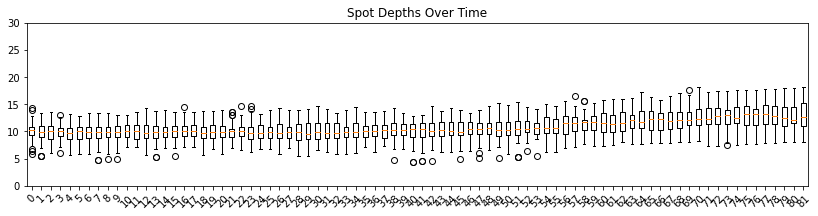

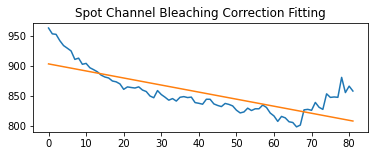

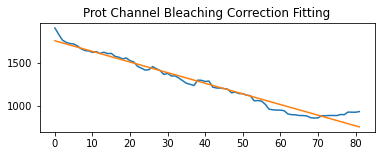

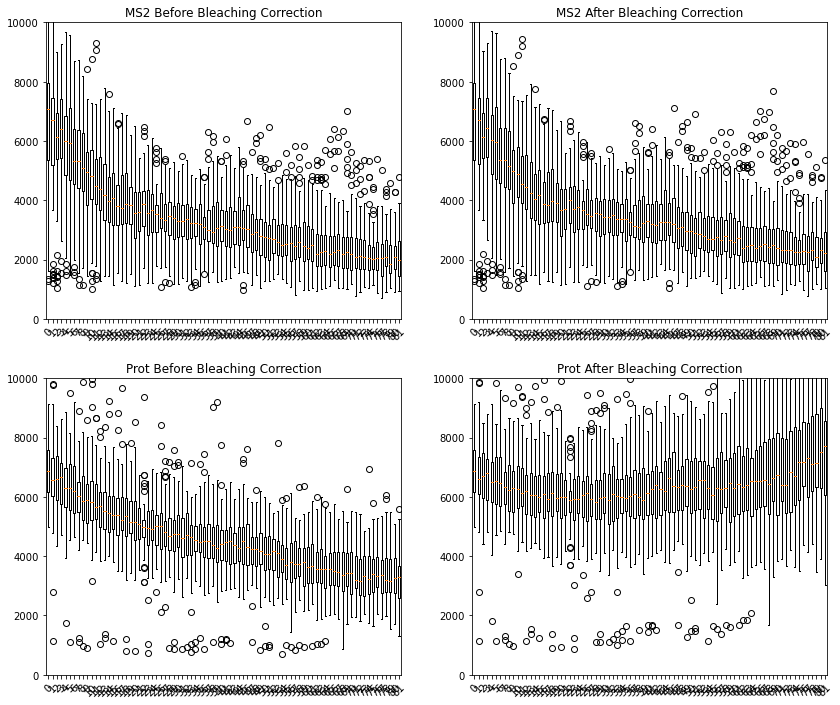

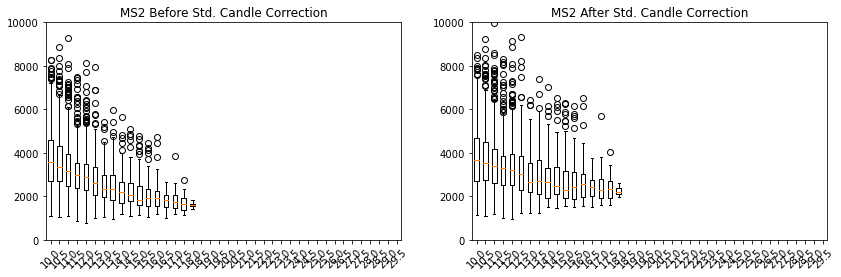

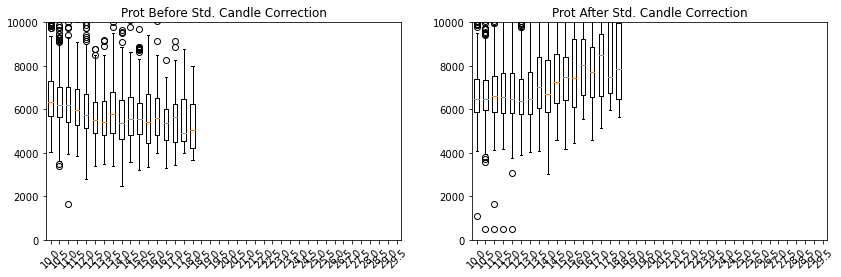

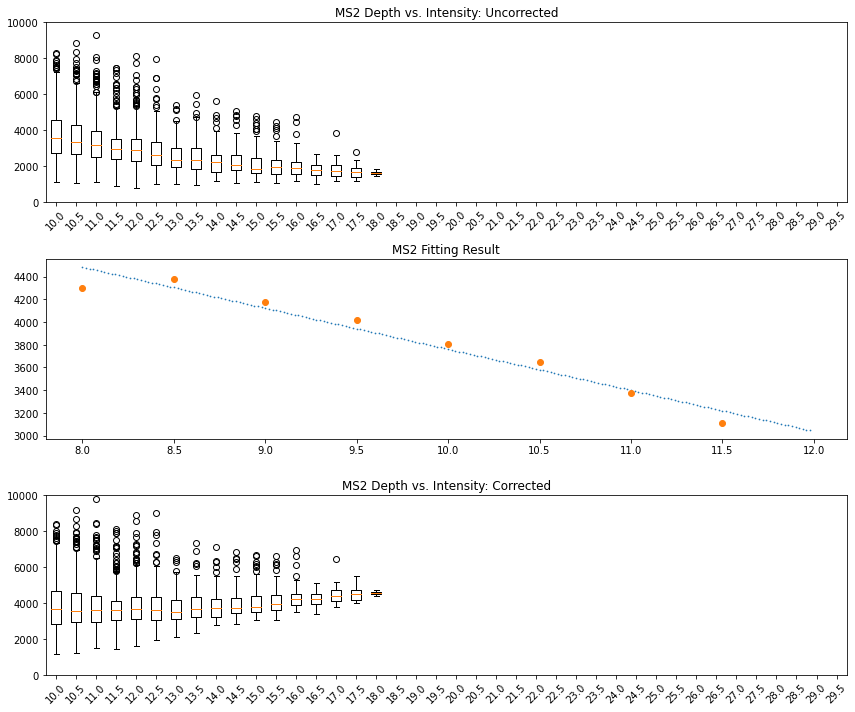

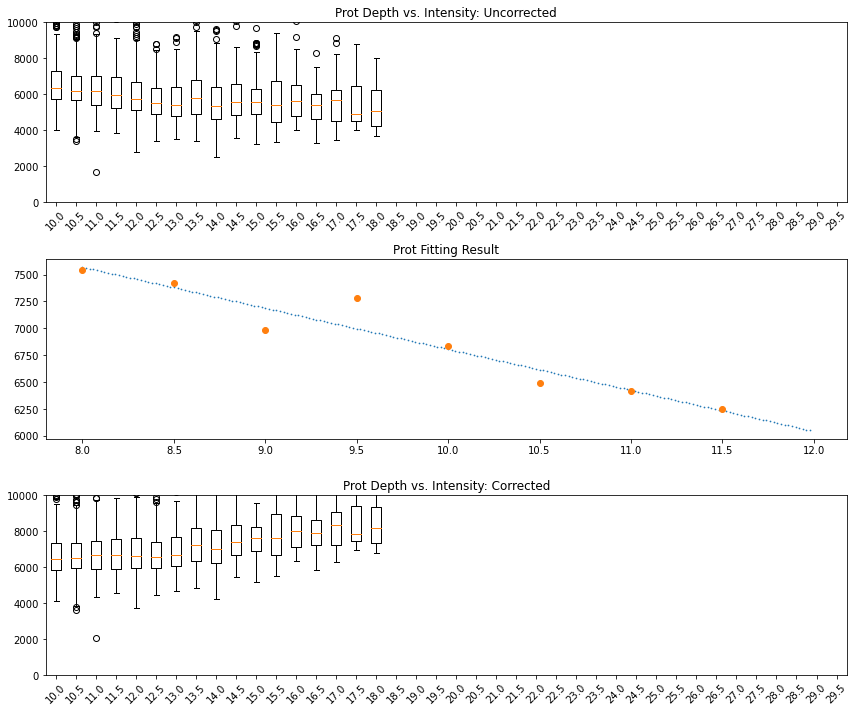

In [30]:
mv = fm.movie(stack, nucmask, fits, spot_data)
fm.analyze.mv_process_apply_corrections(mv, paramgrids, surface_before, surface_after, join_frames, starting_positions, z_interval, ij_rad=5, fit_depth_min=8, fit_depth_max=12)


## 5. QC

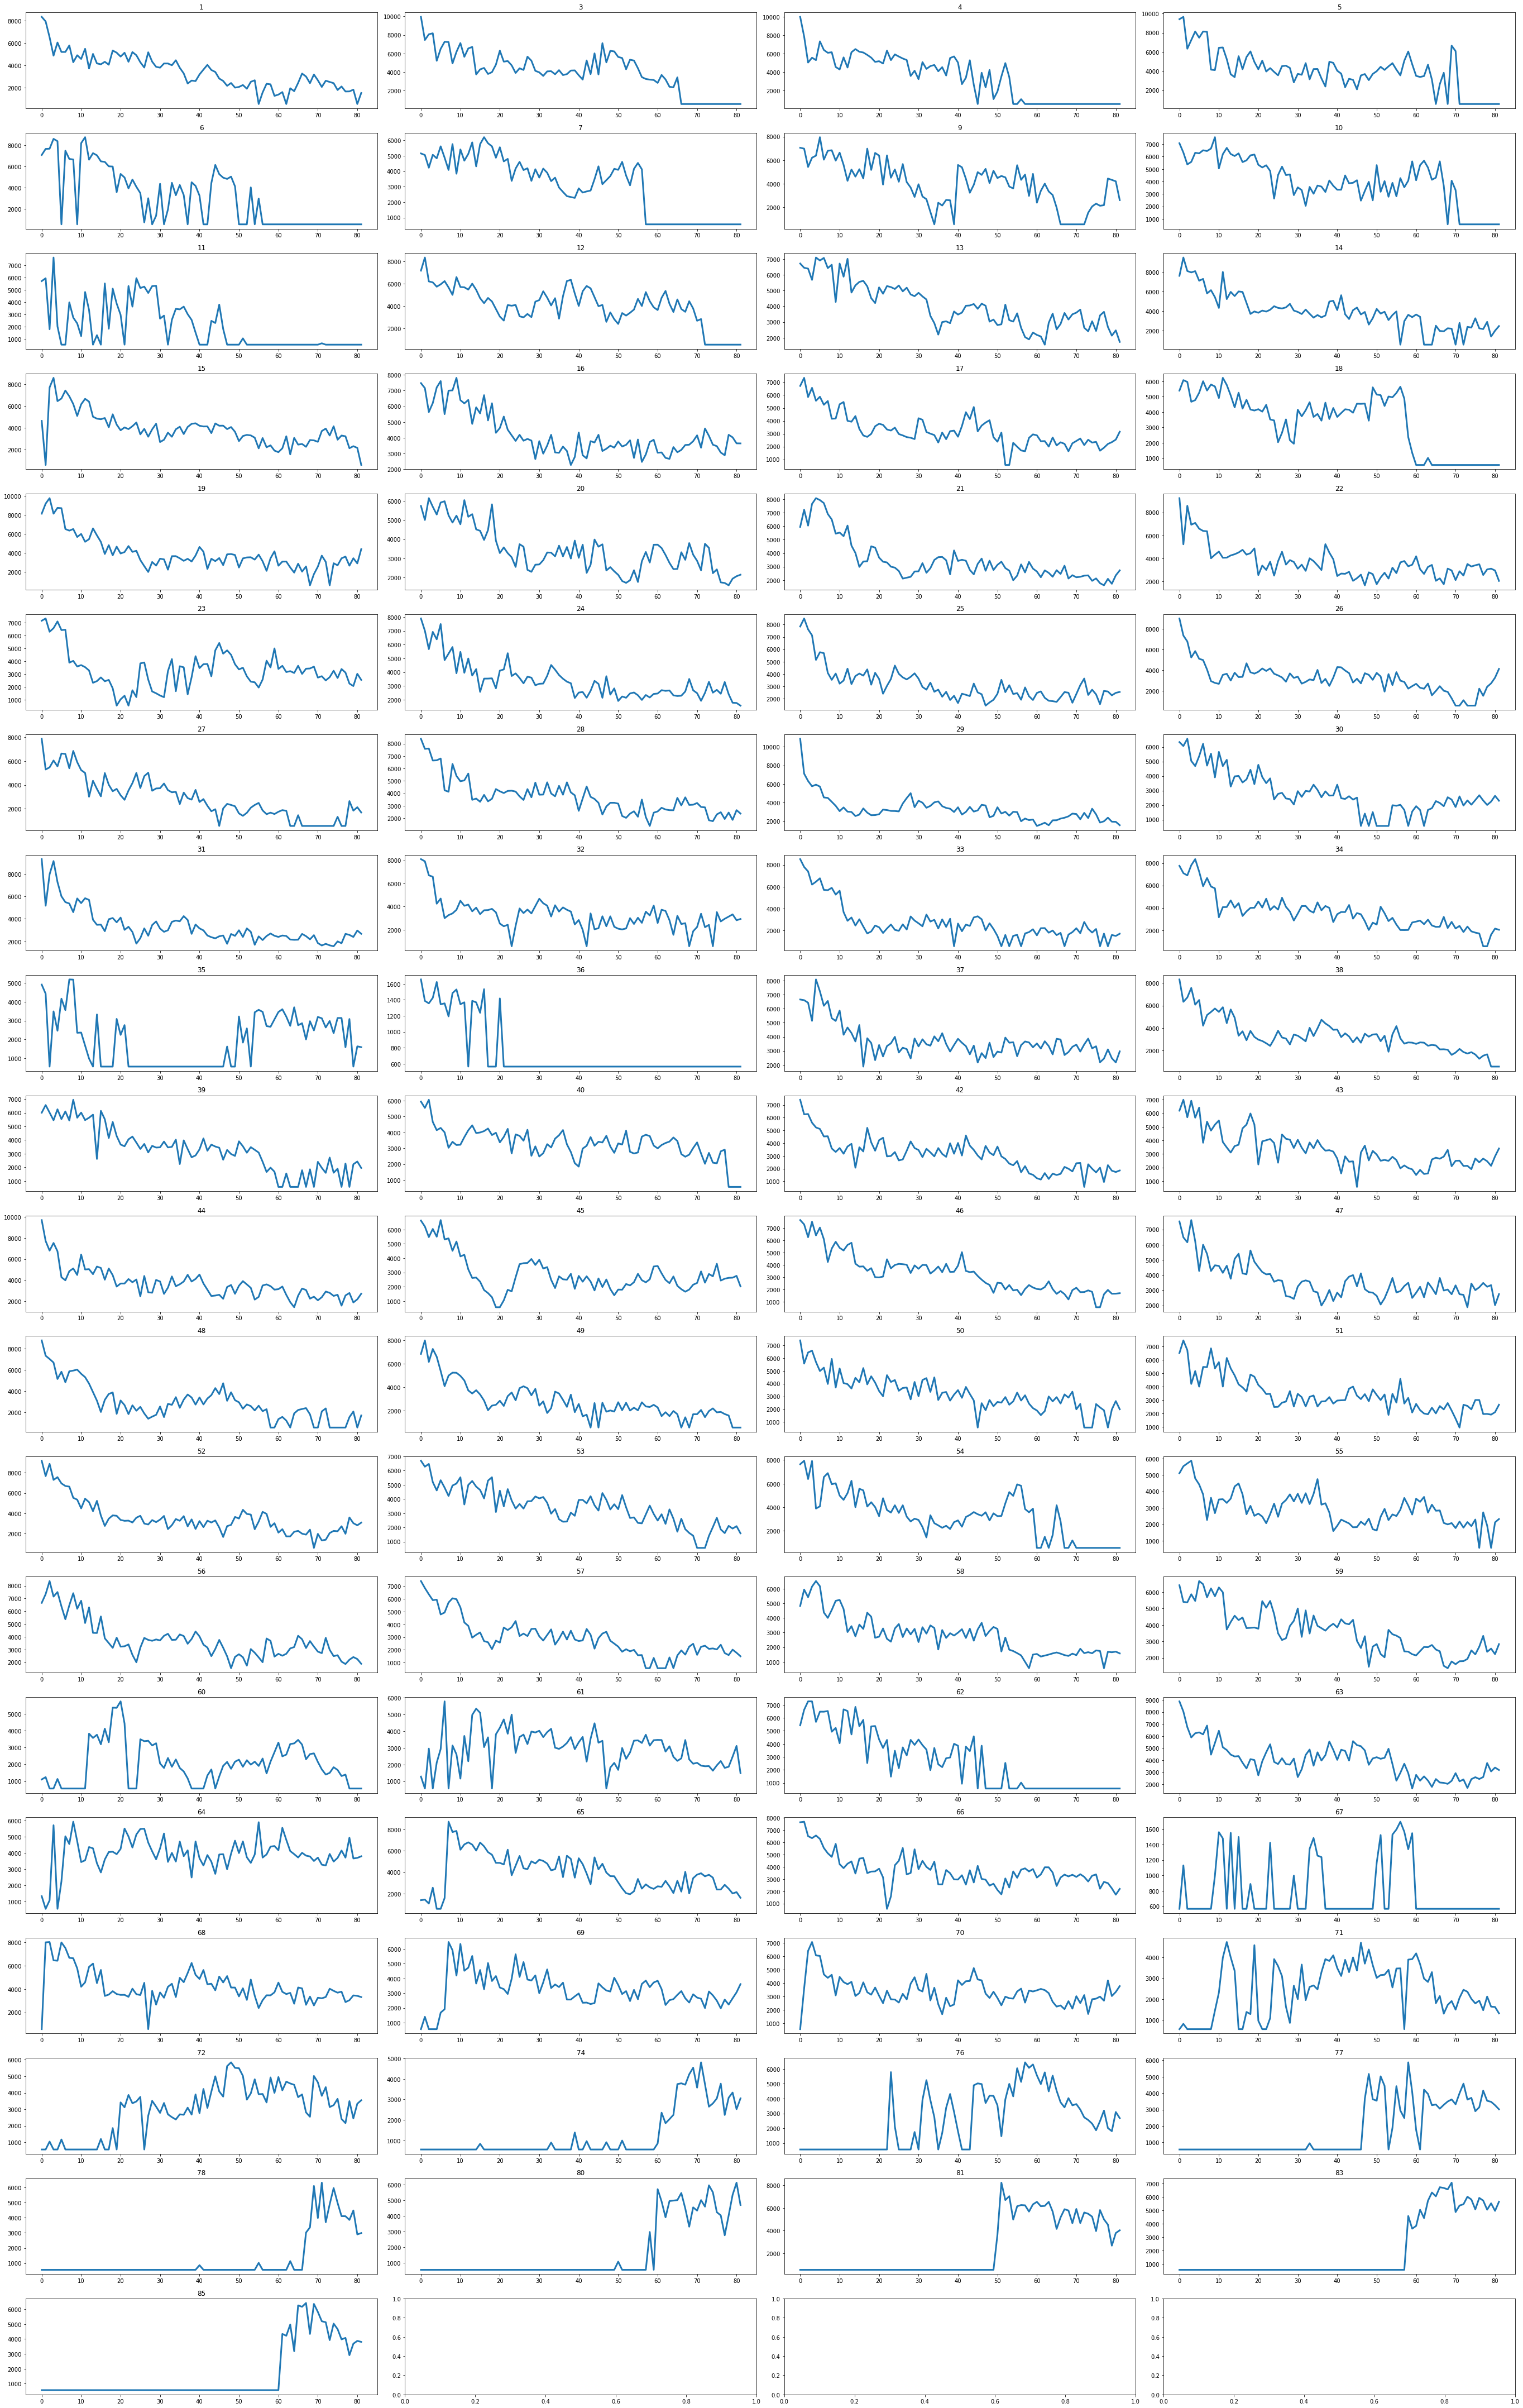

In [32]:
# Plot some traces to see if they look reasonable.
fm.spotdf_plot_traces([mv.ms2_stdcandle], 15, sigma=0.05, norm=False, figsize=(38,60))

In [33]:
# View "spot movies", small boxes of stack data centered on detected spots.
spot_movies = fm.spot_movies(mv.stack, mv.spot_data, channel=1, len_ij=51, fill=0)
# Mean projection of z slices -1 to +1:
fm.viewer(spot_movies[:,:,2:5].mean(axis=2), 5, order='ntxy', color='cividis')
# No projection (with Z axis):
#viewer(spot_movies, 5, order='ntzxy', color='cividis')

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'Gators', 'Reds', 'gray_r', 'inf…

In [ ]:
# Optional: Examine individual spots in original data.
spot_to_view = 42
fm.quickview_ms2(mv.stack, mv.spot_data, channel=1, spot_id=spot_to_view, MAX=True, halfwidth_z=1)

### 6. Save movie

In [34]:
fm.save_pickle(mv, outputfile)